<a href="https://colab.research.google.com/github/NevesGus/StabilityNumericalMethods/blob/main/analyzing%20_stability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Funções e teste

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Métodos Numéricos
def euler_explicit(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    for i in range(1, n):
        u[i] = u[i-1] + (t[i] - t[i-1]) * f(u[i-1], t[i-1])
    return u

def runge_kutta_2(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    for i in range(1, n):
        h = t[i] - t[i-1]
        k1 = f(u[i-1], t[i-1])
        k2 = f(u[i-1] + h/2 * k1, t[i-1] + h/2)
        u[i] = u[i-1] + h * k2
    return u

def runge_kutta_4(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    for i in range(1, n):
        h = t[i] - t[i-1]
        k1 = f(u[i-1], t[i-1])
        k2 = f(u[i-1] + h/2 * k1, t[i-1] + h/2)
        k3 = f(u[i-1] + h/2 * k2, t[i-1] + h/2)
        k4 = f(u[i-1] + h * k3, t[i-1] + h)
        u[i] = u[i-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return u

def adams_bashforth_2(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    if len(t) < 2:
        raise ValueError("Adams-Bashforth requires at least 2 time points")
    u[1] = u[0] + (t[1] - t[0]) * f(u[0], t[0])
    for i in range(2, n):
        h = t[i] - t[i-1]
        u[i] = u[i-1] + h/2 * (-f(u[i-2], t[i-2]) + 3*f(u[i-1], t[i-1]))
    return u

def adams_moulton_2_pc(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    if len(t) < 2:
        raise ValueError("Adams-Moulton requires at least 2 time points")
    u[1] = u[0] + (t[1] - t[0]) * f(u[0], t[0])
    for i in range(2, n):
        h = t[i] - t[i-1]
        up = u[i-1] + h/2 * (-f(u[i-2], t[i-2]) + 3*f(u[i-1], t[i-1]))
        u[i] = u[i-1] + h/12 * (-f(u[i-2], t[i-2]) + 8*f(u[i-1], t[i-1]) + 5*f(up, t[i]))
    return u


def adams_moulton_2_newton(f, u0, t):
    n = len(t)
    u = np.zeros(n, dtype=complex)
    u[0] = u0
    if len(t) < 2:
        raise ValueError("Adams-Moulton requires at least 2 time points")

    # First step using Euler method
    u[1] = u[0] + (t[1] - t[0]) * f(u[0], t[0])

    for i in range(2, n):
        h = t[i] - t[i-1]
        def F(ui):
            return ui - u[i-1] - h/12 * (-f(u[i-2], t[i-2]) + 8*f(u[i-1], t[i-1]) + 5*f(ui, t[i]))

        def F_real_imag(x):
            # Recombine real and imaginary parts into a complex number
            ui_complex = x[0] + 1j * x[1]
            F_value = F(ui_complex)
            return [F_value.real, F_value.imag]

        ui_initial_guess = [u[i-1].real, u[i-1].imag]
        ui_solution = fsolve(F_real_imag, ui_initial_guess)
        u[i] = ui_solution[0] + 1j * ui_solution[1]

    return u


## Calculo da região de estabilidade

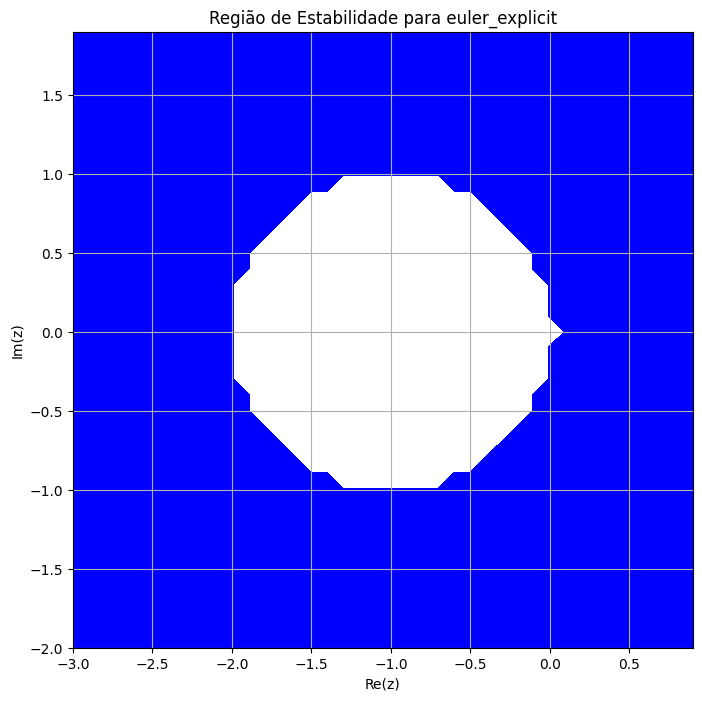

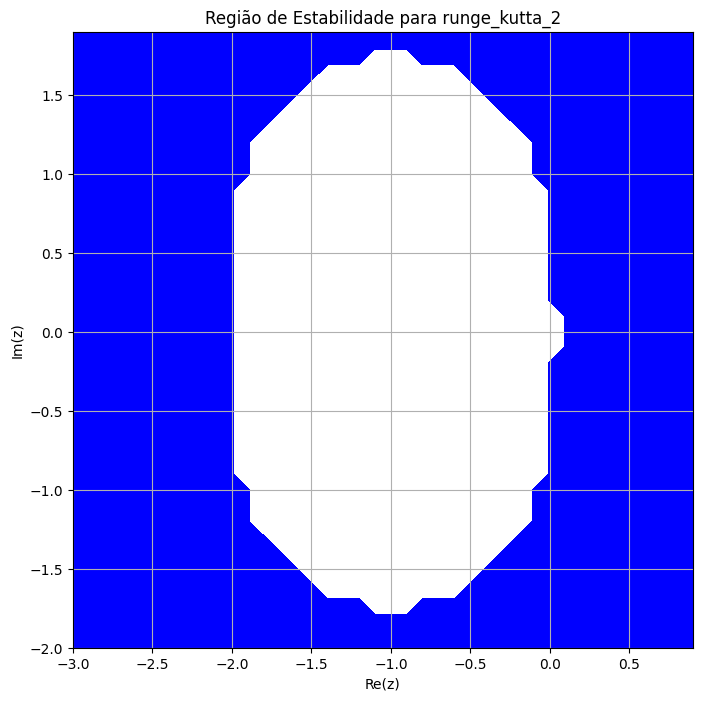

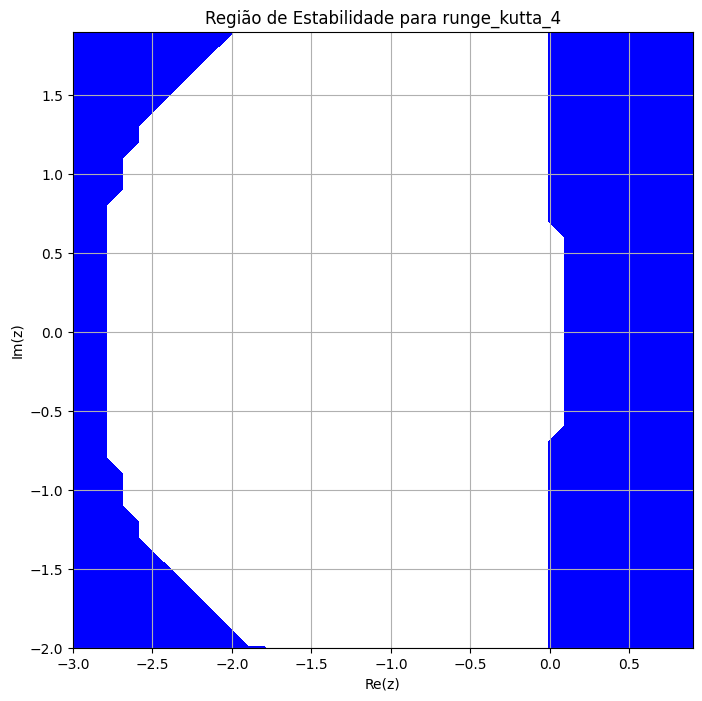

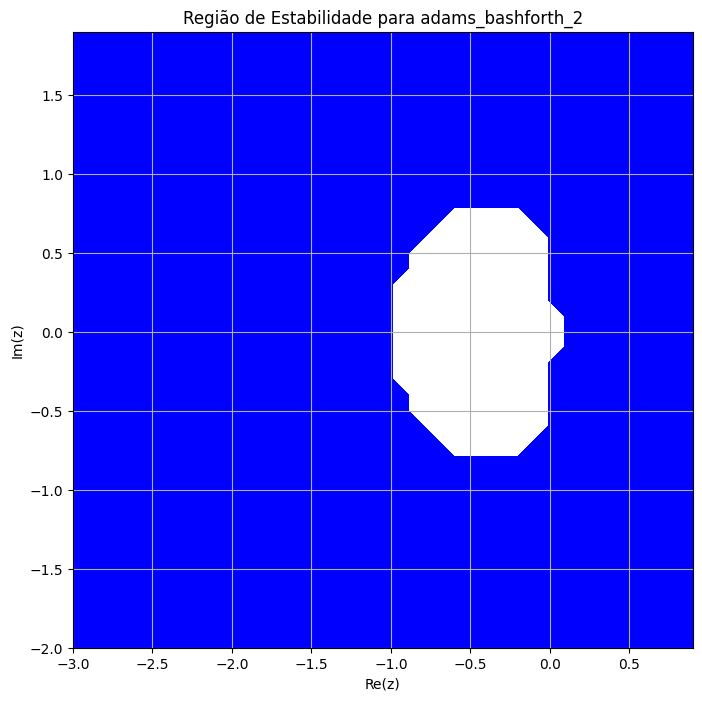

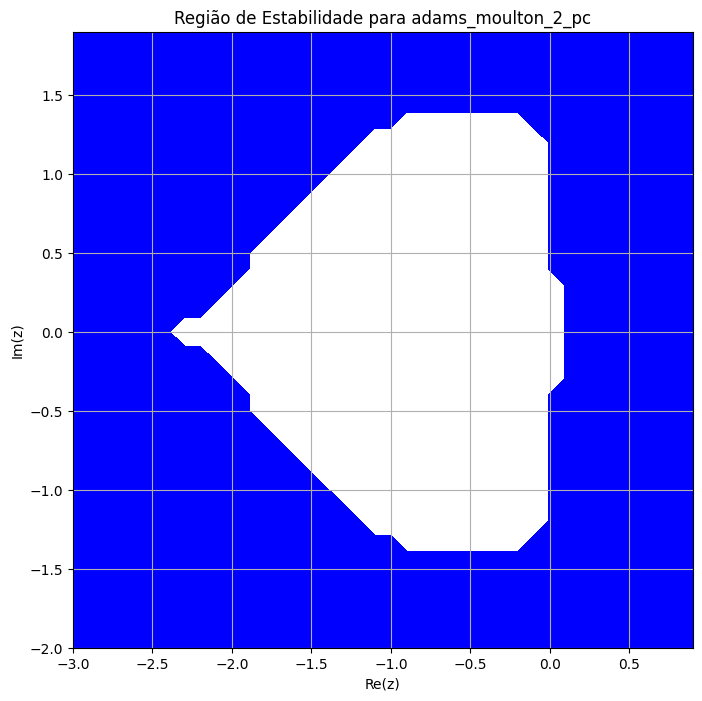

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


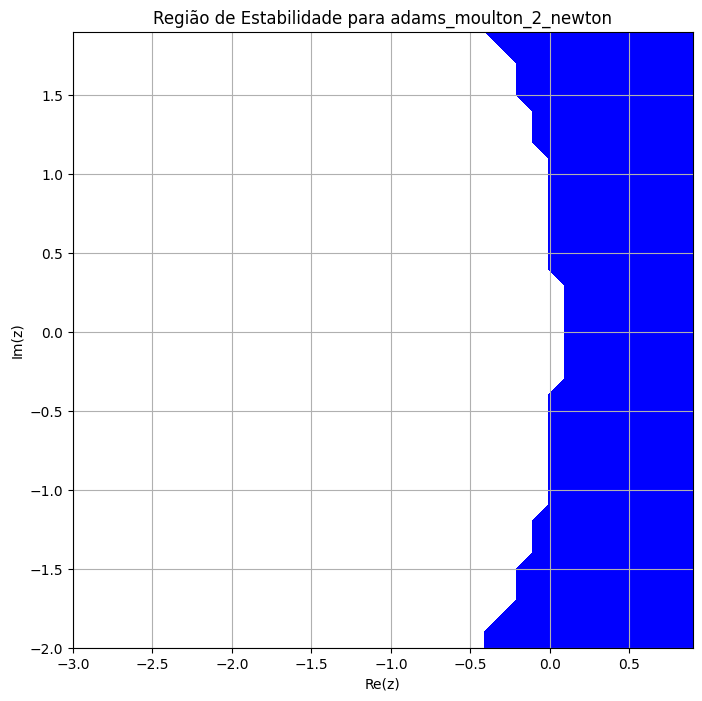

In [ ]:
def stability_region(method, f, u0, t, h, z_real_range, z_imag_range, dz):
    z_real = np.arange(z_real_range[0], z_real_range[1], dz)
    z_imag = np.arange(z_imag_range[0], z_imag_range[1], dz)
    Z_real, Z_imag = np.meshgrid(z_real, z_imag)
    stability = np.zeros(Z_real.shape)

    for i in range(Z_real.shape[0]):
        for j in range(Z_real.shape[1]):
            z = Z_real[i, j] + 1j * Z_imag[i, j]
            lambda_ = z / h
            fz = lambda u, t: lambda_ * u
            u = method(fz, u0, t)
            error = np.abs(u[-1] - np.exp(lambda_ * t[-1]))
            if error < 0.1:
                stability[i, j] = 1
            else:
                stability[i, j] = 0

    plt.figure(figsize=(8, 8))
    plt.contourf(Z_real, Z_imag, stability, levels=[-0.1, 0.1], colors=['blue', 'white'])
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title(f'Região de Estabilidade para {method.__name__}')
    plt.grid(True)
    plt.show()

# Parâmetros
h = 0.1
t = np.arange(0, 10+h, h)
u0 = 1 + 0j  # Valor inicial complexo
z_real_range = [-3, 1]
z_imag_range = [-2, 2]
dz = 0.1

# Métodos a serem testados
methods = [euler_explicit, runge_kutta_2, runge_kutta_4, adams_bashforth_2,
           adams_moulton_2_pc, adams_moulton_2_newton]

# Calcular e plotar a região de estabilidade para cada método
for method in methods:
    stability_region(method, lambda u, t: -u, u0, t, h, z_real_range, z_imag_range, dz)


## gráficos das soluções numéricas produzidas por cada método considerando λ = −1

> Para λ=−1, o valor máximo de h que garante a estabilidade de cada método pode ser estimado a partir das regiões de estabilidade plotadas. Para cada método, vamos usar um valor de h próximo ao limite de estabilidade e plotar as soluções numéricas:

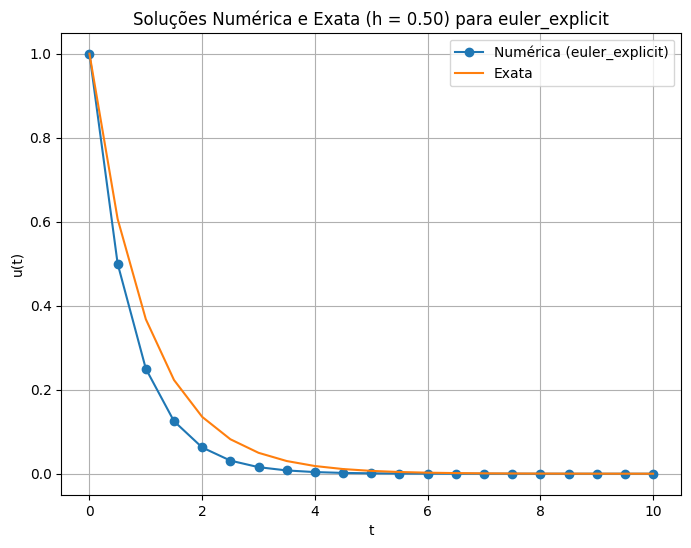

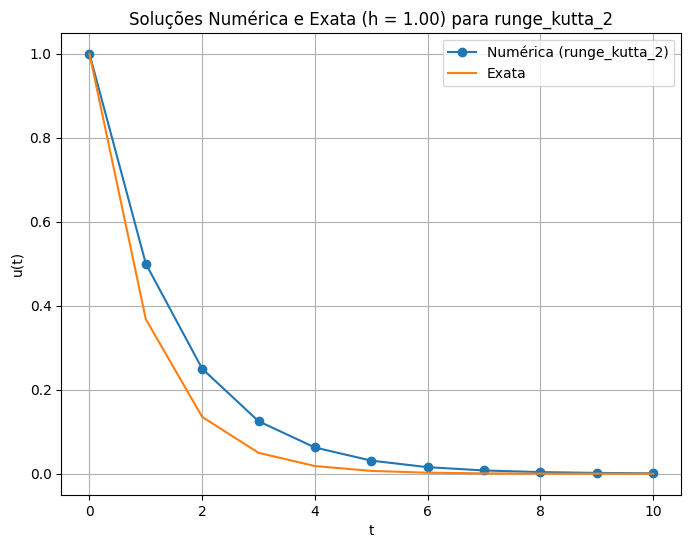

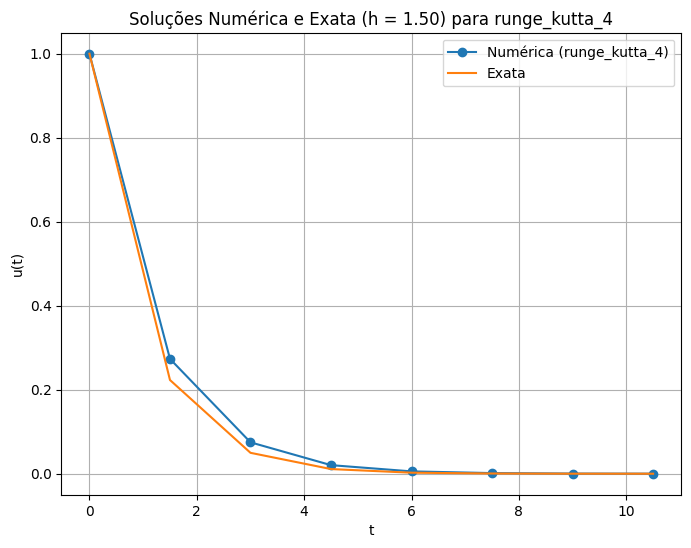

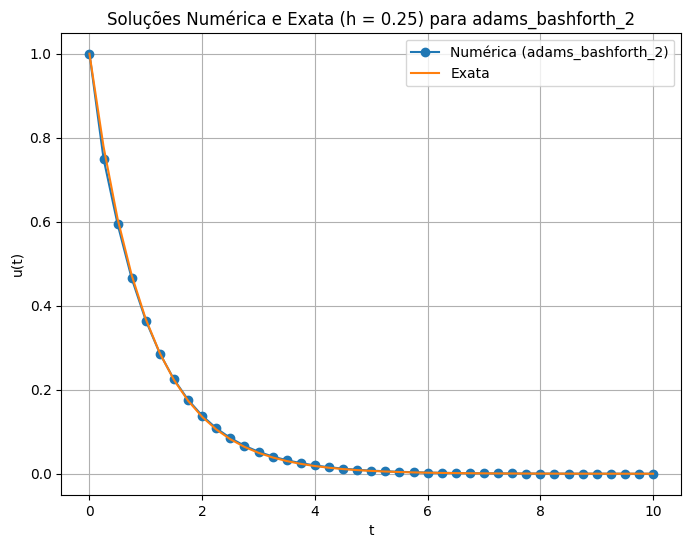

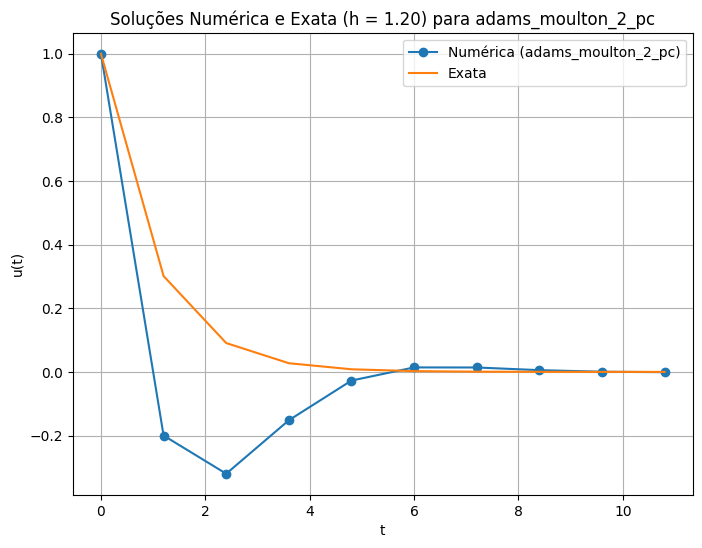

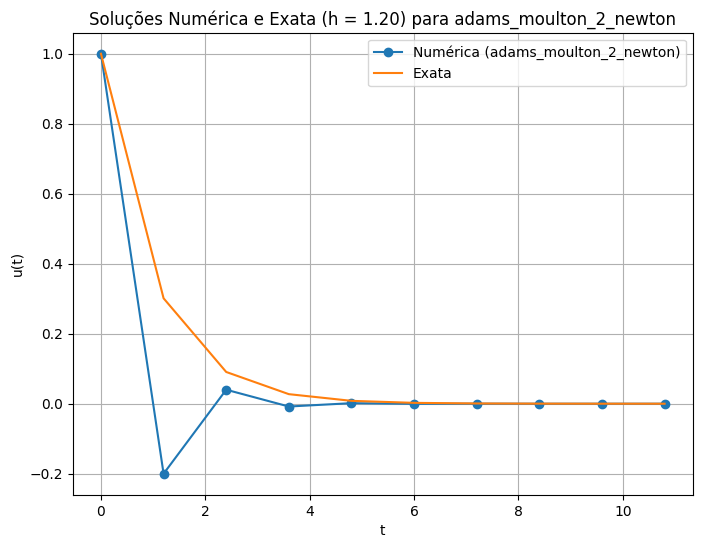

In [ ]:
# Valor de lambda
lambda_ = -1

# Valores máximos de h para cada método (estimados a partir das regiões de estabilidade)
h_max_values = {
    euler_explicit: 0.5,
    runge_kutta_2: 1.0,
    runge_kutta_4: 1.5,
    adams_bashforth_2: 0.25,
    adams_moulton_2_pc: 1.2,
    adams_moulton_2_newton: 1.2,
}

# Plotar soluções numéricas para cada método
for method in methods:
    h_max = h_max_values[method]
    t = np.arange(0, 10 + h_max, h_max)
    f = lambda u, t: lambda_ * u
    u_numerical = method(f, u0, t)
    u_exact = np.exp(lambda_ * t)

    plt.figure(figsize=(8, 6))
    plt.plot(t, u_numerical.real, 'o-', label=f'Numérica ({method.__name__})')
    plt.plot(t, u_exact.real, '-', label='Exata')
    plt.xlabel('t')
    plt.ylabel('u(t)')
    plt.title(f'Soluções Numérica e Exata (h = {h_max:.2f}) para {method.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()

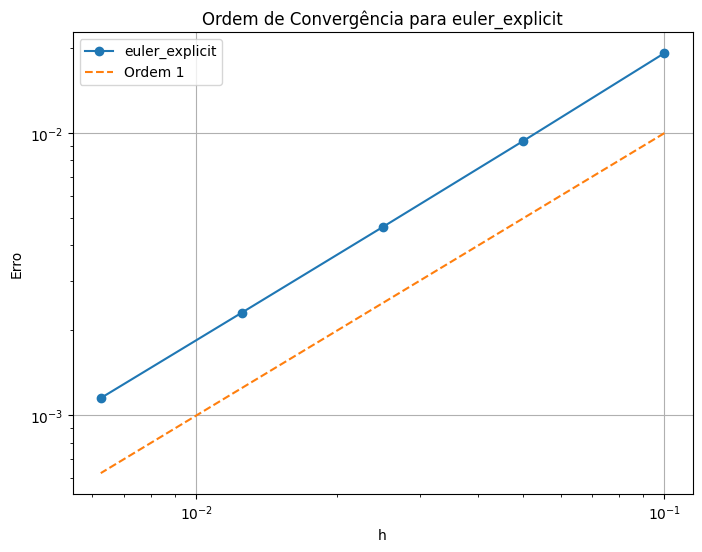

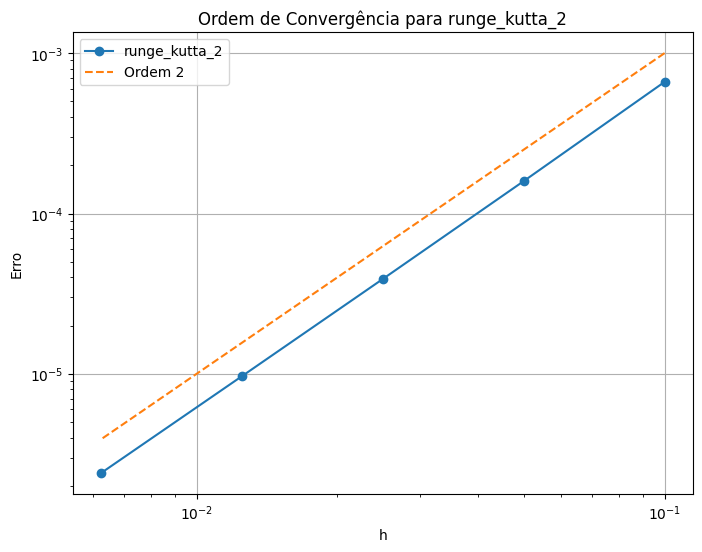

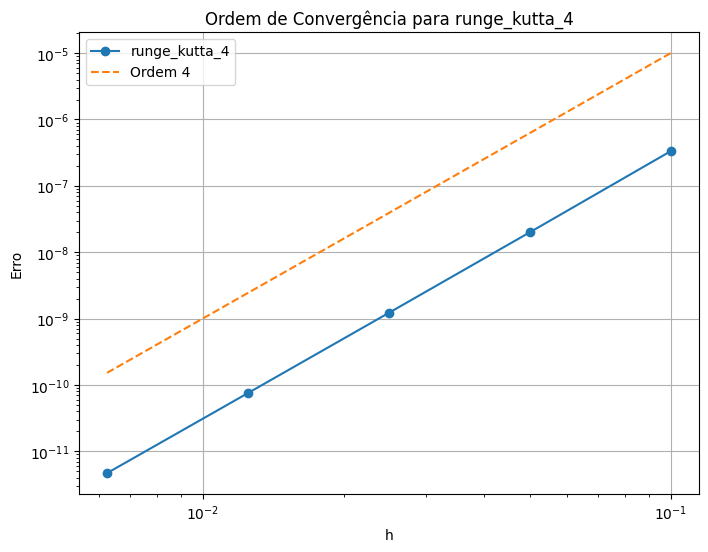

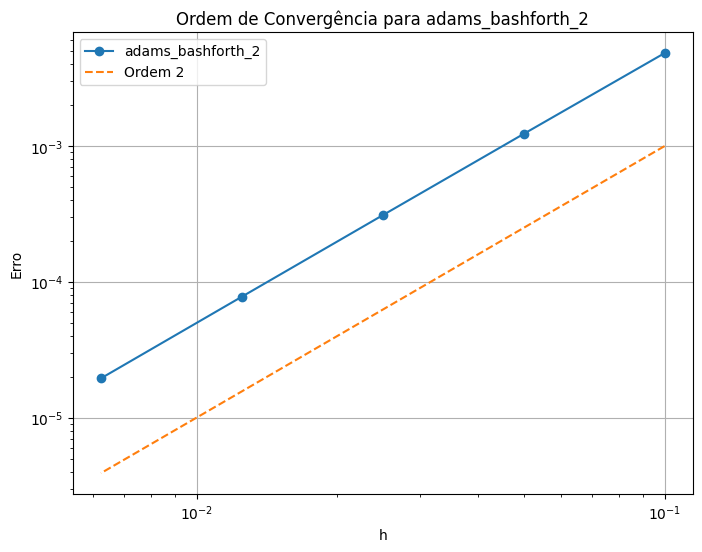

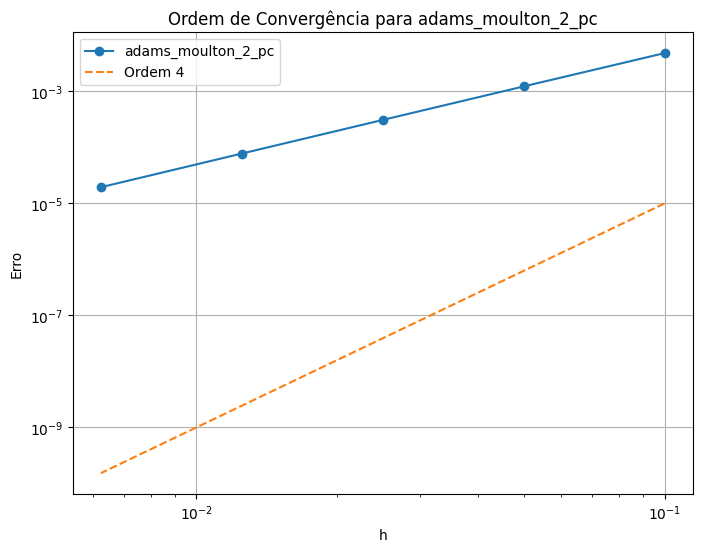

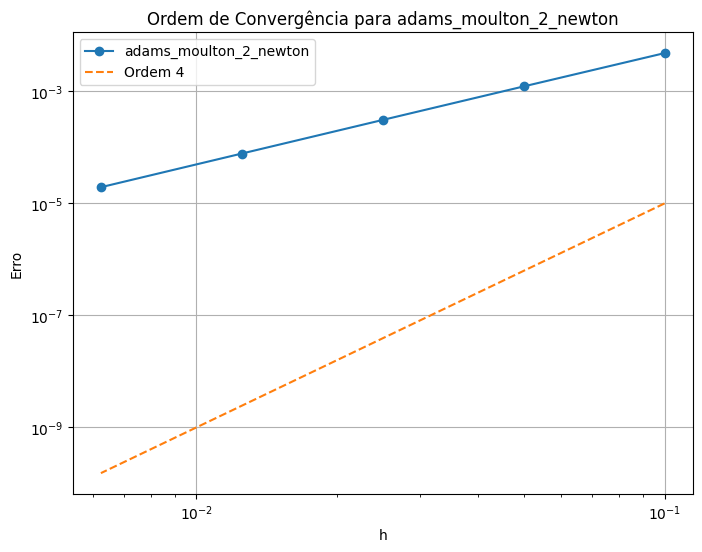

In [ ]:
# Valor de lambda
lambda_ = -1

# Dicionário para armazenar os erros para cada método
errors = {method.__name__: [] for method in methods}

# Calcular erros para diferentes valores de h
for h in [0.1, 0.05, 0.025, 0.0125, 0.00625]:
    t = np.arange(0, 10 + h, h)
    f = lambda u, t: lambda_ * u
    u_exact = np.exp(lambda_ * t)
    for method in methods:
        u_numerical = method(f, u0, t)
        error = np.max(np.abs(u_numerical - u_exact))
        errors[method.__name__].append(error)

# Plotar gráficos de ordem de convergência
for method in methods:
    # Definir a ordem de convergência esperada para cada método
    if method == euler_explicit:
        p = 1
    elif method == runge_kutta_2 or method == adams_bashforth_2:
        p = 2
    elif method == runge_kutta_4 or method == adams_moulton_2_pc or method == adams_moulton_2_newton:
        p = 4
    else:
        p = None  # Caso o método não seja reconhecido

    plt.figure(figsize=(8, 6))
    plt.loglog([0.1, 0.05, 0.025, 0.0125, 0.00625], errors[method.__name__], 'o-', label=method.__name__)
    if p is not None:
        plt.loglog([0.1, 0.05, 0.025, 0.0125, 0.00625], [0.1 * h**p for h in [0.1, 0.05, 0.025, 0.0125, 0.00625]], '--', label=f'Ordem {p}')
    plt.xlabel('h')
    plt.ylabel('Erro')
    plt.title(f'Ordem de Convergência para {method.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()
